In [159]:
from urllib.parse import quote
from urllib.request import urlopen
import json
import pandas as pd

In [160]:
user = "Anyway"
# page=1&limit=24&
uri = """https://api.bar-rts.com/replays?page=1&limit=999&hasBots=false&endedNormally=true&players="""
url = uri+quote(user)

In [161]:
data = json.loads(urlopen(url).read().decode("utf-8"))

In [162]:
with open(f"data_{user}.json", "w") as outfile:
    json.dump(data["data"], outfile, indent=4, sort_keys=True)

In [163]:
# Get the winning team and count the number of wins
match = {}
matches = []
for game in data["data"]:
    for team in game["AllyTeams"]:
        for player in team["Players"]:
            if player["name"] == user:
                match = {
                    **match,
                    **{
                        "id": game["id"],
                        "name": player["name"],
                        "winningTeam": team["winningTeam"],
                        "Map.fileName": game["Map"]["fileName"],
                        "Map.scriptName": game["Map"]["scriptName"],
                        "durationMs": game["durationMs"],
                        "startTime": game["startTime"],
                    },
                }
                matches.append(match)

In [164]:
df = pd.json_normalize(matches) #put json inside a dataframe
df

,id,name,winningTeam,Map.fileName,Map.scriptName,durationMs,startTime
0,4658a164bd9d7401375219a2e7fff62b,yotoniko0,True,comet_catcher_remake_1.8,Comet Catcher Remake 1.8,1603300,2023-07-02T10:58:14.000Z
1,1f679f643ab090679f7c32bfa9002d53,yotoniko0,True,ascendancy_v2.0,Ascendancy v2.0,1928567,2023-06-30T23:37:03.000Z
2,96599f64d1e8a6f86388662c3cc34140,yotoniko0,True,dsdr_4.1,DSDR 4.1,2072533,2023-06-30T22:39:18.000Z
3,144e9f644d1d05de7e13bae550e4d59c,yotoniko0,False,bismuth_valley_v2.2,Bismuth Valley v2.2,2393833,2023-06-30T21:50:12.000Z
4,43469f641229db1832e3b3bc912150b7,yotoniko0,True,forge_v1.4,Forge v1.4,1409867,2023-06-30T21:16:51.000Z
...,...,...,...,...,...,...,...
474,fec4b563258fb30ce4719cac96406c65,yotoniko0,False,boulder_beach_v1,Boulder_Beach_V1,1536567,2023-01-04T18:27:10.000Z
475,f9b0b56352c47cea09893b0cb927e99c,yotoniko0,False,altored_divide_bar_remake_1.6,Altored Divide Bar Remake 1.6,1818867,2023-01-04T17:01:45.000Z
476,dea3b563c29a85b9ba5df0f3007a1516,yotoniko0,False,titan_v3.1,Titan v3.1,2582733,2023-01-04T16:05:50.000Z
477,5199b563172cdfd65b4ac4358422c716,yotoniko0,True,titan_v3.1,Titan v3.1,2039100,2023-01-04T15:20:49.000Z


In [165]:
df['winningTeam'].value_counts(normalize=True)[True] * 100


56.36743215031316

<Figure size 800x600 with 0 Axes>

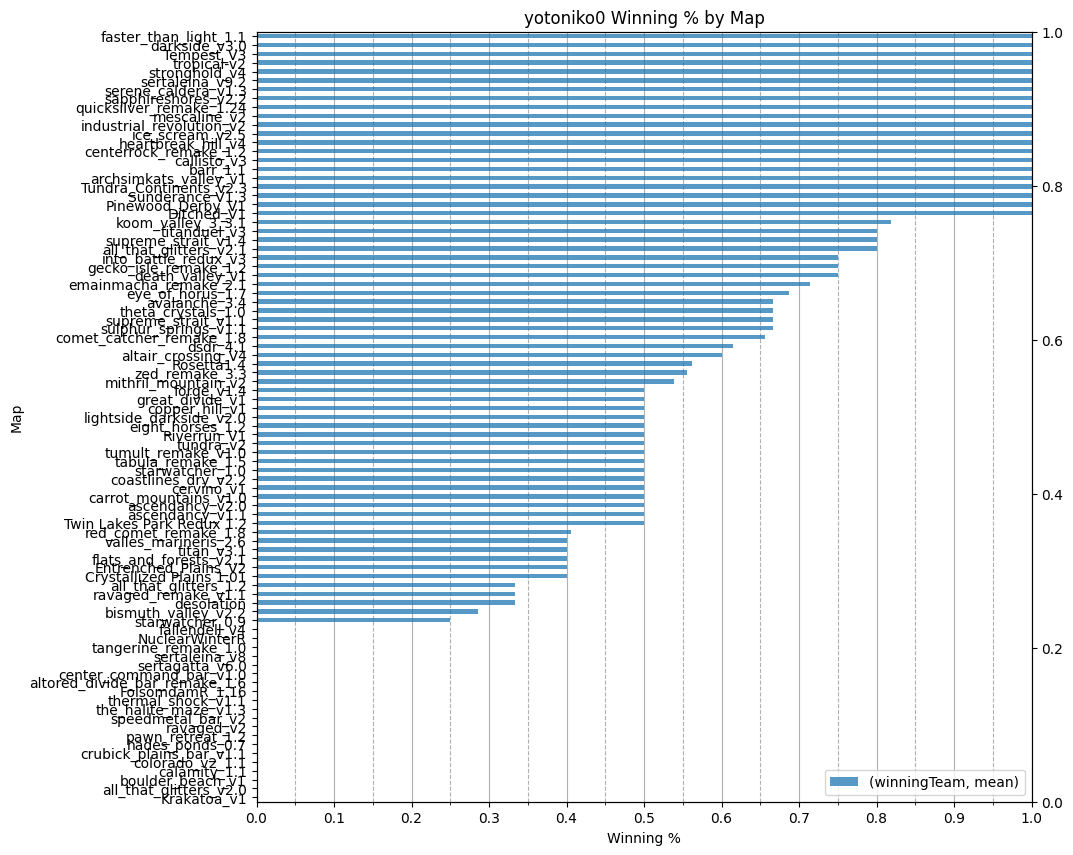

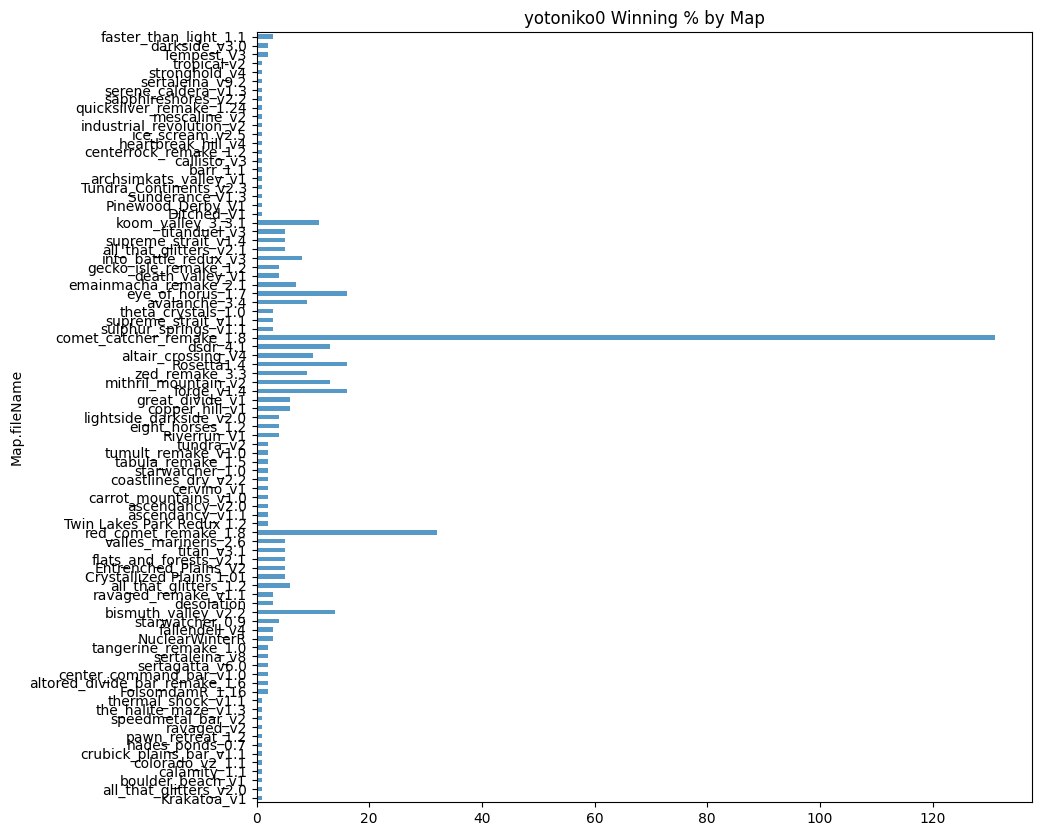

In [166]:
# Get the winning % for each map sorted by winning % and number of games played
# Set larger figure size

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams["figure.figsize"] = (10, 10)

win_rate = (
    df.groupby(["Map.fileName"])
    .agg({"winningTeam": ["mean", "count"]})
    .sort_values([("winningTeam", "mean"), ("winningTeam", "count")], ascending=True)
)

# Use win_rate and plot the winning % for each map with the number of games played with horizontal bars and subdivide the bars by the winning team
# with minor locator for the x axis. Color by count and winningTeam.

# Set the x axis minor locator to 5 and major locator to 10

fig = plt.figure(figsize=(8, 6))

ax = win_rate.plot.barh(
    y=("winningTeam", "mean"),
    secondary_y=("winningTeam", "count"),
    alpha=0.75,
    legend=False,
    title=f"{user} Winning % by Map",
)

ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.05))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.grid(which="minor", axis="x", linestyle="--")
ax.grid(which="major", axis="x", linestyle="-")
ax.set_xlabel("Winning %")
ax.set_ylabel("Map")
ax.set_xlim(0, 1)

ax.set_yticklabels(win_rate.index)
ax.set_axisbelow(True)
ax.legend(loc="lower right")

ax2 = ax.twinx()
ax2 = win_rate.plot.barh(
    y=("winningTeam", "count"),
    secondary_y=("winningTeam", "count"),
    alpha=0.75,
    legend=False,
    title=f"{user} Winning % by Map",
)

plt.show()

In [167]:
win_rate

winningTeam      
                              mean count
Map.fileName                            
Krakatoa_v1                    0.0     1
all_that_glitters_v2.0         0.0     1
boulder_beach_v1               0.0     1
calamity_1.1                   0.0     1
colorado_v2_1.1                0.0     1
...                            ...   ...
stronghold_v4                  1.0     1
tropical-v2                    1.0     1
Tempest_V3                     1.0     2
darkside_v3.0                  1.0     2
faster_than_light_1.1          1.0     3

[87 rows x 2 columns]

In [168]:
# Get the overall win rate

df["winningTeam"].mean() * 100

56.36743215031316

In [169]:
# Get the winning % for each map sorted by winning % and number of games played

df.groupby(['Map.fileName','winningTeam']).size().unstack().fillna(0).apply(lambda x: x / x.sum(), axis=1)

# df.groupby(["Map.fileName"]).agg({"winningTeam": ["count", "mean"]}).sort_values(
#     [("winningTeam", "mean")], ascending=False
# )

winningTeam,False,True
Map.fileName,,
Crystallized Plains 1.01,0.600000,0.400000
Ditched_V1,0.000000,1.000000
Entrenched_Plains_V2,0.600000,0.400000
FolsomdamR_1.16,1.000000,0.000000
Krakatoa_v1,1.000000,0.000000
...,...,...
tropical-v2,0.000000,1.000000
tumult_remake_v1.0,0.500000,0.500000
tundra_v2,0.500000,0.500000
